#### Energy minimizer

Step 0: energy=-45.637 boxgas=100.797 boxliq=12.995 totalvol=1026285.695
Step 0: energy_gas=-0.000 energy_liquid=-45.636
Step 100: energy=-1765.052 boxgas=100.859 boxliq=6.592 totalvol=1026285.689
Step 100: energy_gas=-1.594 energy_liquid=-1763.459
Step 200: energy=-2156.521 boxgas=100.861 boxliq=6.178 totalvol=1026285.760
Step 200: energy_gas=-3.149 energy_liquid=-2153.373
Step 300: energy=-2155.803 boxgas=100.861 boxliq=6.181 totalvol=1026285.731
Step 300: energy_gas=-2.384 energy_liquid=-2153.419
Final energy: -2155.468 Final boxgas: tensor(100.8609, requires_grad=True) Final boxliq: tensor(6.1814, grad_fn=<PowBackward0>)


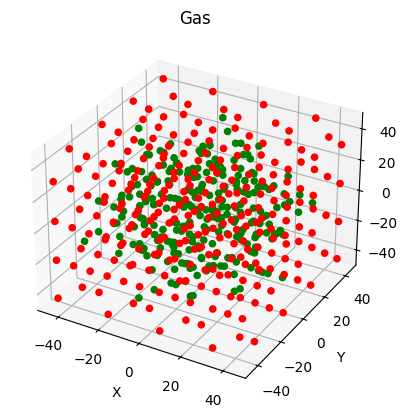

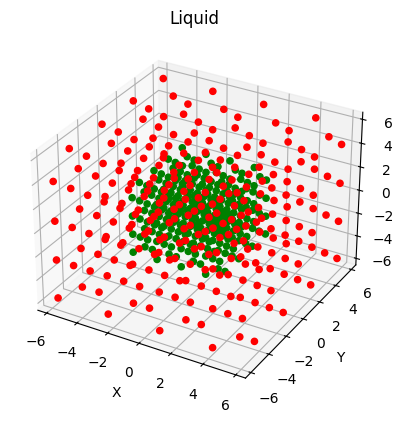

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import random as rand
from main import *
#%matplotlib qt
%matplotlib inline

def loop(rxgas, rygas, rzgas, rxliq, ryliq, rzliq, ex, ey, ez, emx, emy, emz, boxgas, boxliq, ngas, nliq, lr=0.003, iterations=400):
    coordinate_matrix_gas=torch.tensor([rxgas, rygas, rzgas]).requires_grad_()
    boxgas=torch.tensor(boxgas).requires_grad_()
    coordinate_matrix_liq=torch.tensor([rxliq, ryliq, rzliq]).requires_grad_()
    boxliq=torch.tensor(boxliq).requires_grad_()
    coordinate_matrix_e=torch.tensor([ex, ey, ez]).requires_grad_()
    coordinate_matrix_em=torch.tensor([emx, emy, emz]).requires_grad_()

    pointsgas = torch.split(coordinate_matrix_gas, 1, dim=1)
    rxgas, rygas, rzgas = torch.split(coordinate_matrix_gas, 1, dim=0)
    pointsliq = torch.split(coordinate_matrix_liq, 1, dim=1)
    rxliq, ryliq, rzliq = torch.split(coordinate_matrix_liq, 1, dim=0)

    rxgasc=(rxgas.clone().detach().numpy())*(boxgas.clone().detach().numpy())
    rygasc=(rygas.clone().detach().numpy())*(boxgas.clone().detach().numpy())
    rzgasc=(rzgas.clone().detach().numpy())*(boxgas.clone().detach().numpy())
    boxgasc=(boxgas.clone().detach().numpy())

    rxliqc=(rxliq.clone().detach().numpy())*(boxliq.clone().detach().numpy())
    ryliqc=(ryliq.clone().detach().numpy())*(boxliq.clone().detach().numpy())
    rzliqc=(rzliq.clone().detach().numpy())*(boxliq.clone().detach().numpy())
    boxliqc=(boxliq.clone().detach().numpy())

    optimizer = torch.optim.Adam([coordinate_matrix_gas, boxgas, coordinate_matrix_liq], lr=lr, weight_decay=0)

    for i in range(iterations):
        optimizer.zero_grad()
        ug, dg, tg, mg, sg, eg, scaleg, bg =energy(coordinate_matrix_gas, boxgas, coordinate_matrix_e, coordinate_matrix_em, ngas)
        ul, dl, tl, ml, sl, el, scalel, bl = energy(coordinate_matrix_liq, (vol-(boxgas**3))**(1/3), coordinate_matrix_e, coordinate_matrix_em, nliq)
        u=ul+ug
        u.backward()
        optimizer.step()
        if i % 100 == 0:
            boxliq=(vol-(boxgas**3))**(1/3)
            print(f"Step {i}: energy={u.item():.3f} boxgas={boxgas.item():.3f} boxliq={boxliq.item():.3f} totalvol={(boxgas.item()**3)+(boxliq.item()**3):.3f}")
            print(f"Step {i}: energy_gas={ug:.3f} energy_liquid={ul:.3f}")

    print('Final energy:', u.detach().numpy(), 'Final boxgas:', boxgas, 'Final boxliq:', boxliq)

    pointsgas = torch.split(coordinate_matrix_gas, 1, dim=1)
    rxgas, rygas, rzgas = torch.split(coordinate_matrix_gas, 1, dim=0)
    pointsliq = torch.split(coordinate_matrix_liq, 1, dim=1)
    rxliq, ryliq, rzliq = torch.split(coordinate_matrix_liq, 1, dim=0)

    rxgaso=((rxgas-torch.round(rxgas)).clone().detach().numpy())*(boxgas.clone().detach().numpy())
    rygaso=((rygas-torch.round(rygas)).clone().detach().numpy())*(boxgas.clone().detach().numpy())
    rzgaso=((rzgas-torch.round(rzgas)).clone().detach().numpy())*(boxgas.clone().detach().numpy())

    rxliqo=((rxliq-torch.round(rxliq)).clone().detach().numpy())*(boxliq.clone().detach().numpy())
    ryliqo=((ryliq-torch.round(ryliq)).clone().detach().numpy())*(boxliq.clone().detach().numpy())
    rzliqo=((rzliq-torch.round(rzliq)).clone().detach().numpy())*(boxliq.clone().detach().numpy())

    plotparticles(rxgaso, rygaso, rzgaso, rxgasc, rygasc, rzgasc, 'Gas', boxgasc)

    plotparticles(rxliqo, ryliqo, rzliqo, rxliqc, ryliqc, rzliqc, 'Liquid', boxliqc)

ngas, nliq, n, rxgas, rygas, rzgas, rxliq, ryliq, rzliq, ex, ey, ez, emx, emy, emz, boxliq, boxgas, cutgas2, cutliq2 = initia()

loop(rxgas, rygas, rzgas, rxliq, ryliq, rzliq, ex, ey, ez, emx, emy, emz, boxgas, boxliq, ngas, nliq, 0.003, 400)